# Convolutional LSTM

In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUS,", len(logical_gpus), "Logical GPUS")
    except RuntimeError as e:
        print(e)

tf.keras.backend.set_floatx('float32')
tf.keras.backend.set_epsilon(1e-4)

1 Physical GPUS, 1 Logical GPUS


In [2]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

Using TensorFlow backend.


In [13]:
# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [47]:
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [48]:
seq.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_33 (ConvLSTM2D) (None, None, 40, 40, 20)  15200     
_________________________________________________________________
batch_normalization_33 (Batc (None, None, 40, 40, 20)  80        
_________________________________________________________________
conv_lst_m2d_34 (ConvLSTM2D) (None, None, 40, 40, 20)  28880     
_________________________________________________________________
batch_normalization_34 (Batc (None, None, 40, 40, 20)  80        
_________________________________________________________________
conv_lst_m2d_35 (ConvLSTM2D) (None, None, 40, 40, 20)  28880     
_________________________________________________________________
batch_normalization_35 (Batc (None, None, 40, 40, 20)  80        
_________________________________________________________________
conv_lst_m2d_36 (ConvLSTM2D) (None, None, 40, 40, 20) 

In [49]:
# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=120, validation_split=0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/120
950/950 [==============================] - 60s 63ms/step - loss: 0.3003 - val_loss: 0.3638
Epoch 2/120
950/950 [==============================] - 209s 220ms/step - loss: 0.0377 - val_loss: 0.2965
Epoch 3/120
950/950 [==============================] - 155s 164ms/step - loss: 0.0245 - val_loss: 0.1652
Epoch 4/120
950/950 [==============================] - 138s 145ms/step - loss: 0.0187 - val_loss: 0.0418
Epoch 5/120
950/950 [==============================] - 135s 142ms/step - loss: 0.0121 - val_loss: 0.0160
Epoch 6/120
950/950 [==============================] - 128s 134ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 7/120
950/950 [==============================] - 128s 134ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/120
950/950 [==============================] - 128s 134ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/120
950/950 [==============================] - 128s 134ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/120

950/950 [==============================] - 128s 134ms/step - loss: 2.6140e-04 - val_loss: 2.9806e-04
Epoch 74/120
950/950 [==============================] - 127s 134ms/step - loss: 2.5968e-04 - val_loss: 2.9542e-04
Epoch 75/120
950/950 [==============================] - 127s 134ms/step - loss: 2.5998e-04 - val_loss: 2.9206e-04
Epoch 76/120
950/950 [==============================] - 127s 134ms/step - loss: 2.5418e-04 - val_loss: 2.9080e-04
Epoch 77/120
950/950 [==============================] - 127s 134ms/step - loss: 2.5011e-04 - val_loss: 2.8546e-04
Epoch 78/120
950/950 [==============================] - 127s 134ms/step - loss: 2.4864e-04 - val_loss: 2.8171e-04
Epoch 79/120
950/950 [==============================] - 127s 134ms/step - loss: 2.4678e-04 - val_loss: 2.8100e-04
Epoch 80/120
950/950 [==============================] - 127s 134ms/step - loss: 2.4393e-04 - val_loss: 2.7636e-04
Epoch 81/120
950/950 [==============================] - 127s 134ms/step - loss: 2.4122e-04 - val_loss

In [50]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 400
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

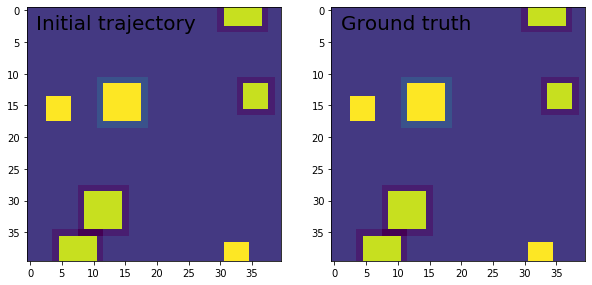

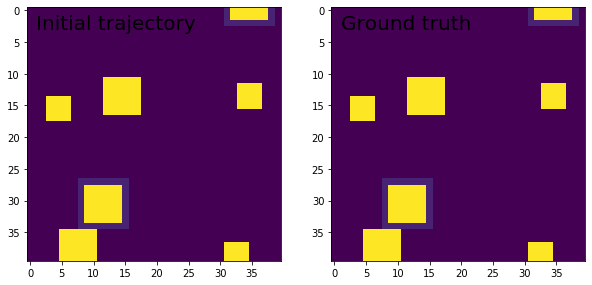

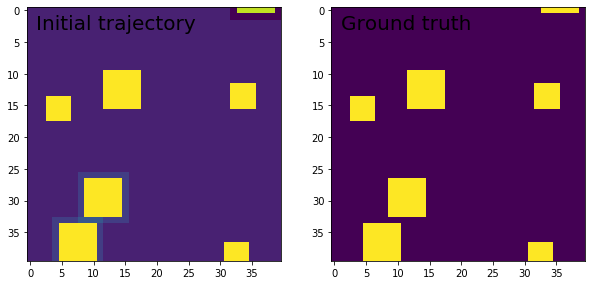

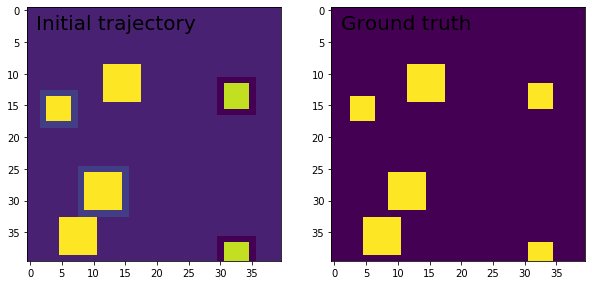

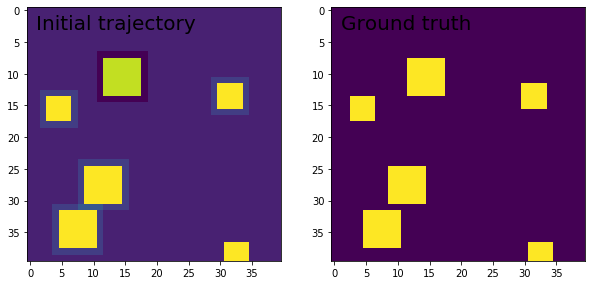

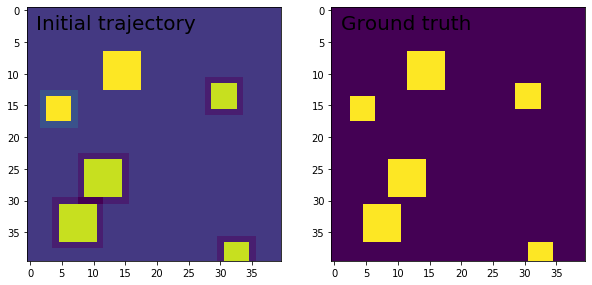

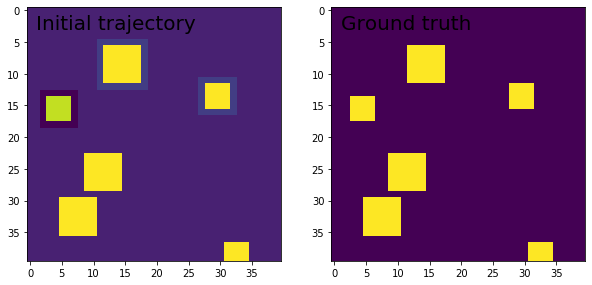

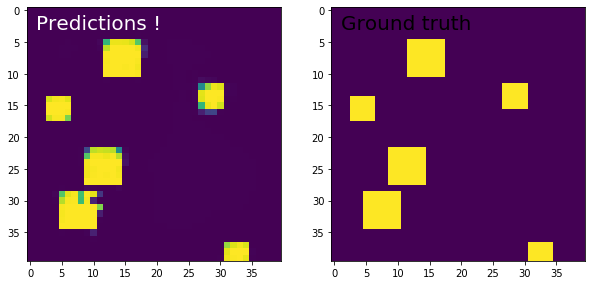

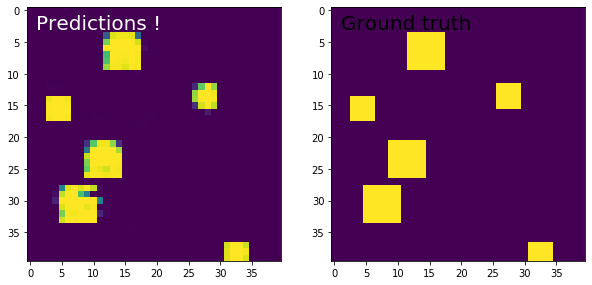

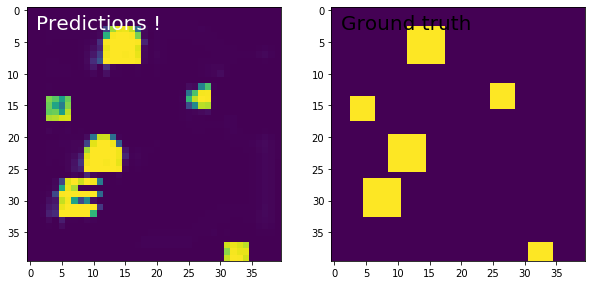

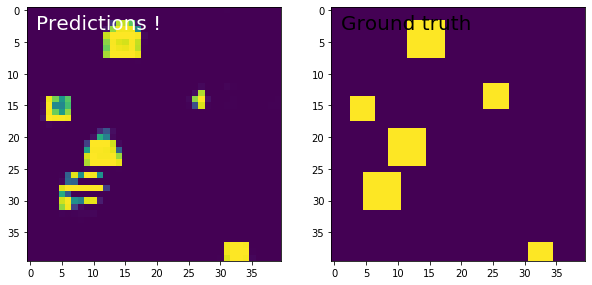

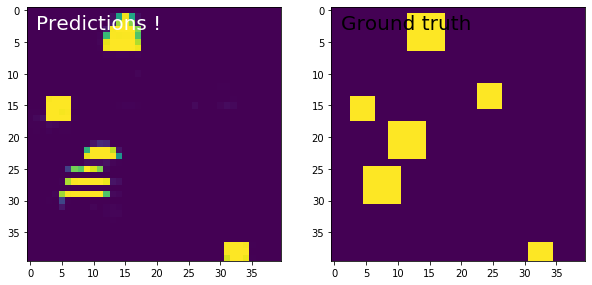

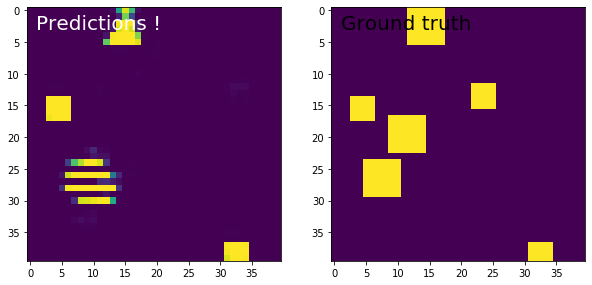

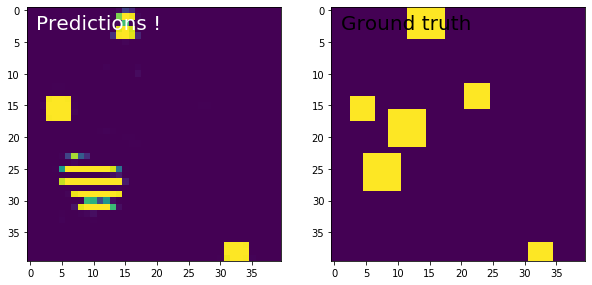

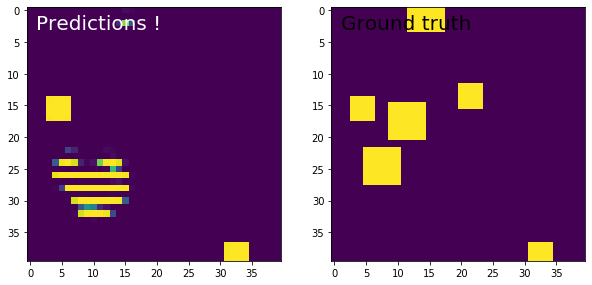

In [52]:
# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    #plt.savefig('%i_animate.png' % (i + 1))